In [1]:
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


from models.t0 import T0RegressionModel
from datahandles import TabLLMDataObject, FewshotTabLLMDataset, CombinedTabLLMTextDataset
from tabllm.dataset_utils import load_dataset, balance_dataset, load_and_preprocess_dataset
from utils import Config, ConfigObject

os.environ["HF_HOME"] = "/export/pasan/.cache/huggingface"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/afs/glue.umd.edu/home/glue/p/a/pasand/home/miniconda3/envs/transhyper2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap='Blues'):
    """
    Displays a confusion matrix.

    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels
    - class_names: list of class names (optional)
    - normalize: whether to normalize the matrix (default: False)
    - cmap: color map for the heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

In [3]:
ds_name = "income"
checkpoint_path = f"save/t0pp-{ds_name}-finonly/epoch-1.pth"

checkpoint_path = f"save/t0pp-test/epoch-last.pth"

checkpoint = torch.load(checkpoint_path, weights_only=False)

cfg_dict = checkpoint["cfg"]
cfg_dict["datasets"]["balanced"] = {"train": True, "val": False, "test": False}
cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
cfg_dict["datasets"]["test_ratio"] = 0.8
cfg_dict["datasets"]["validation_ratio"] = 0.1
cfg_dict["debug"] = False
cfg = Config(cfg_dict=cfg_dict)

tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=True)
test_ds = CombinedTabLLMTextDataset(cfg=cfg, split="test", datapoints=[tabllm_do.split_datapoints[ds_name]], max_n_features=cfg.hyponet.in_dim())

y = np.array([test_ds[i]["y"] for i in range(len(test_ds))])
X = np.array([test_ds[i]["x"] for i in range(len(test_ds))])
print(f"X.shape: {X.shape}, y.shape: {y.shape}")

X.shape: (39074, 103), y.shape: (39074,)


In [4]:
model = T0RegressionModel(cfg=cfg)
model.load_state_dict(checkpoint['model'])
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer.model())

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
def compute_metrics(n_shots):
    prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=n_shots)])
    # prompt = "sdjhf skdjfhsd akfjal"
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')
    hyponet = model(tokens)
    hyponet.eval()
    preds = hyponet.forward(torch.Tensor(X).unsqueeze(dim=0))
    preds = preds.detach().numpy()
    preds = np.squeeze(preds)
    preds = np.argmax(preds, axis=1)

    val_counts = pd.DataFrame(y).value_counts()
    const_pred_acc = max(val_counts)/sum(val_counts) * 100
    balanced_acc = balanced_accuracy_score(y, preds) * 100
    f1 = f1_score(y, preds) * 100
    unbalanced_acc = accuracy_score(y, preds) * 100

    return {
        "preds": preds,
        "const_predictor_acc": const_pred_acc,
        "balanced_acc": balanced_acc,
        "f1_score": f1,
        "unbalanced_acc": unbalanced_acc
    }

Dataset: income
Prediction shape: (39074,)
Max const. predictor acc: 76.20
Hyponet balanced acc: 66.69
Hyponet F1 score: 49.19
Hyponet unbalanced acc: 74.93


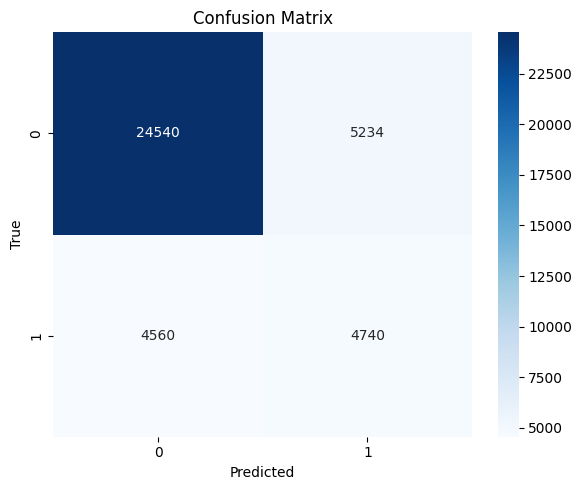

In [6]:
print(f"Dataset: {ds_name}")

metrics = compute_metrics(n_shots=128)
print(f"Prediction shape: {metrics['preds'].shape}")
print(f"Max const. predictor acc: {metrics['const_predictor_acc']:.2f}")
print(f"Hyponet balanced acc: {metrics['balanced_acc']:.2f}")
print(f"Hyponet F1 score: {metrics['f1_score']:.2f}")
print(f"Hyponet unbalanced acc: {metrics['unbalanced_acc']:.2f}")


plot_confusion_matrix(y_true=y, y_pred=metrics["preds"])

In [7]:
balanced_acc = []
unbalanced_acc = []
f1 = []
n_shots = [4, 8, 16, 32, 64, 128]

for i in n_shots:
    metrics = compute_metrics(n_shots=i)
    balanced_acc.append(metrics['balanced_acc'])
    unbalanced_acc.append(metrics['unbalanced_acc'])
    f1.append(metrics['f1_score'])

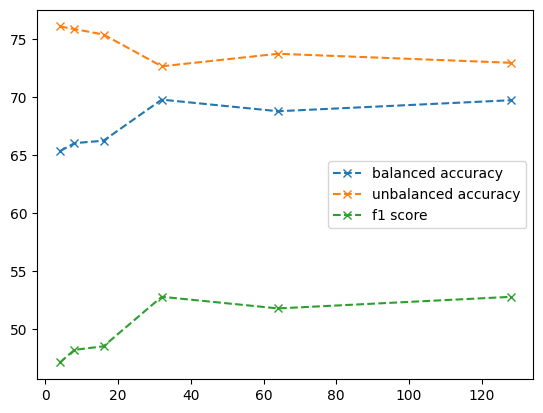

In [8]:
plt.plot(n_shots, balanced_acc, 'x--', label="balanced accuracy")
plt.plot(n_shots, unbalanced_acc, 'x--', label="unbalanced accuracy")
plt.plot(n_shots, f1, 'x--', label="f1 score")
plt.legend()
plt.show()